In [2]:
# !pip install datasets

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset
https://huggingface.co/datasets/huggan/wikiart

In [5]:
def plot_histogram(data, title):
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=range(min(data), max(data) + 2), edgecolor='black')
    plt.title(title)
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.show()

In [33]:
dataset = load_dataset("huggan/wikiart", split="train")

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/45 [00:00<?, ?it/s]

In [35]:
print(f"Total number of records: {len(dataset)}")
print(f"Number of columns: {len(dataset.column_names)}")
print(dataset.column_names)

Total number of records: 81444
Number of columns: 4
['image', 'artist', 'genre', 'style']


In [36]:
unique_genres = set(dataset['genre'])
print(f"Number of genres: {unique_genres.__len__()}")
print(f"Unique genres: {unique_genres}")

Number of genres: 11
Unique genres: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


In [37]:
unique_style = set(dataset['style'])
print(f"Number of styles: {unique_style.__len__()}")
print(f"Unique styles: {unique_style}")

Number of styles: 27
Unique styles: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


We will be using only 2 columns: image and genre

In [38]:
df = pd.DataFrame(dataset['genre'], columns=['genre'])

genre_counts = df['genre'].value_counts()
sorted_counts = genre_counts.sort_index(ascending=True)

sorted_counts_df = pd.DataFrame(sorted_counts).reset_index()
sorted_counts_df.columns = ['genre', 'count']
#sorted_counts_df.style.hide_index()


In [ ]:
plot_histogram(dataset['genre'], "Distribution of Genres")

Concerning disproportion  in distribution of genres. This may negatively impact the classification results. 

In [ ]:
list_of_images = []
for genre in unique_genres:
    for i in range(len(dataset)):
        if dataset[i]['genre'] == genre:
            list_of_images.append(dataset[i]['image'])
            break

In [13]:
plt.figure(figsize=(20, 20))
for i in range(len(list_of_images)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(list_of_images[i])
    plt.title(f"Genre {i + 1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


<Figure size 2000x2000 with 0 Axes>

## ViT

In [3]:
from transformers import ViTImageProcessor, ViTForImageClassification

In [4]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')


In [5]:
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer

dataset = load_dataset("huggan/wikiart", split="train")
dataset = dataset.select(range(2000))
dataset = dataset.filter(lambda x: x['genre'] is not None)

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/45 [00:00<?, ?it/s]

Encoding genre labels

In [7]:
genres = list(set(dataset['genre']))
label2id = {g: i for i, g in enumerate(genres)}
id2label = {i: g for g, i in label2id.items()}


def encode_labels(example):
    example['label'] = label2id[example['genre']]
    return example


dataset = dataset.map(encode_labels)

Preprocessing images

In [8]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

def preprocess(example):
    inputs = processor(images=example['image'], return_tensors="pt")
    example['pixel_values'] = inputs['pixel_values'][0]
    return example

dataset = dataset.map(preprocess)

Splitting dataset into train and test sets

In [9]:
def collate_fn(examples):
    pixel_values = torch.stack([
        torch.tensor(example["pixel_values"]) if not isinstance(example["pixel_values"], torch.Tensor)
        else example["pixel_values"]
        for example in examples
    ])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [10]:
split = dataset.train_test_split(test_size=0.2)
train_dataset = split['train']
eval_dataset = split['test']

In [11]:
# Initialize the ViT model with your genre classes
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(genres),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
train_args = TrainingArguments(
    output_dir="output-models",
    per_device_train_batch_size=16,
    num_train_epochs=2,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
    eval_strategy='steps'
)

In [13]:
import numpy as np
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": (preds == labels).mean()}


In [14]:
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn
)
trainer.train()

Step,Training Loss,Validation Loss
10,1.932700,1.646668
20,1.687400,1.521328
30,1.371900,1.437903
40,1.373300,1.294222
50,1.293100,1.223035
60,1.291400,1.138757
70,1.138400,1.238583
80,1.278700,1.043511
90,1.063600,1.037326
100,1.052900,0.990417


TrainOutput(global_step=200, training_loss=0.8893015611171723, metrics={'train_runtime': 1137.7292, 'train_samples_per_second': 2.813, 'train_steps_per_second': 0.176, 'total_flos': 2.479921468932096e+17, 'train_loss': 0.8893015611171723, 'epoch': 2.0})

In [15]:
outputs = trainer.predict(eval_dataset)
print(outputs.metrics)

{'test_loss': 0.919725775718689, 'test_runtime': 38.4688, 'test_samples_per_second': 10.398, 'test_steps_per_second': 1.3}


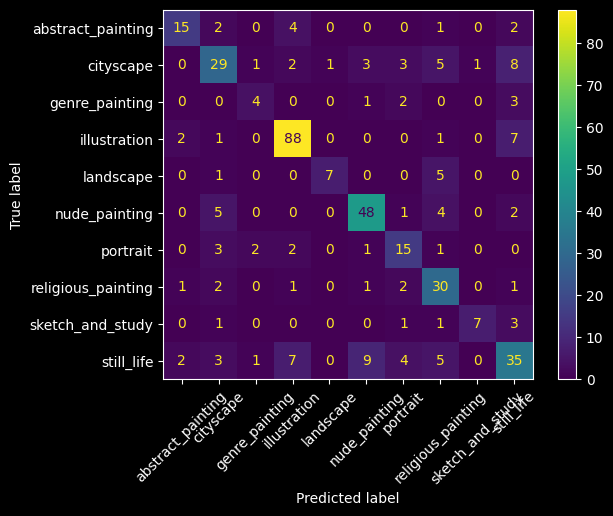

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.style.use('dark_background')

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_dataset.features["genre"].names
cm = confusion_matrix(y_true, y_pred)
if len(labels) != cm.shape[0]:
    labels = labels[:cm.shape[0]]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [32]:
from sklearn.metrics import classification_report

target_names = id2label.values()

print(classification_report(y_true, y_pred, target_names=labels))

                    precision    recall  f1-score   support

 abstract_painting       0.75      0.62      0.68        24
         cityscape       0.62      0.55      0.58        53
    genre_painting       0.50      0.40      0.44        10
      illustration       0.85      0.89      0.87        99
         landscape       0.88      0.54      0.67        13
     nude_painting       0.76      0.80      0.78        60
          portrait       0.54      0.62      0.58        24
religious_painting       0.57      0.79      0.66        38
  sketch_and_study       0.88      0.54      0.67        13
        still_life       0.57      0.53      0.55        66

          accuracy                           0.69       400
         macro avg       0.69      0.63      0.65       400
      weighted avg       0.70      0.69      0.69       400

